# 3D (x-y-t) field inference: more than 2 platforms (Nxy>=2), uncorrelated platforms


In [1]:
import os
from tqdm import tqdm
#import pickle

import numpy as np
import pandas as pd
import xarray as xr
import dask

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import corner
import arviz as az

import nwatools.stats as st
day = 86400

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


/home1/datawork/aponte/code/pynsitu/pynsitu/__init__.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  hour = Timedelta("1H")
ERROR 1: PROJ: proj_create_from_database: Open of /home1/datawork/aponte/miniconda3/envs/equinox/share/proj failed


In [2]:
# actually run production inferences
#prod=True
prod=False

local_cluster = True
#if prod:
#    local_cluster = False

if local_cluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
else:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=20, processes=20, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="00:30:00")
    # cores=7, processes=7, 02:00:00 by default
    w = cluster.scale(jobs=5)

client = Client(cluster)
client

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-message

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44309,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:56622,Total threads: 7
Dashboard: http://127.0.0.1:54296/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:38469,


## Prepare distribution of computations

Computations to be distributed:

- Fixed station inference
- Lagrangian simulation and inference


In [3]:
# flow case
U = "0.1"
case = "3D_matern32_iso_matern12_pp_r0.0_u"+U

uv = True # True if u and v are observed
parameter_eta_formulation = False # eta vs nu formulation
noise = 0.01 # observation noise added to u/v
no_time = False # activates time inference
#traj_decorrelation = False  # artificially decorrelate different moorings/drifters
traj_decorrelation = True  # artificially decorrelate different moorings/drifters

# number of points used for inference#
#Nxy, Nt = 1, 50
Nxy, Nt = 2, 50
#Nxy, Nt = 5, 50
#Nxy, Nt = 10, 50

# run multiple Nxy at once
Nxy = [1, 2, 4, 8, 16]

# number of ensembles
#Ne = 10 # dev
Ne = 100 # prod

dx = None
#dx = 100. # Nxy>1, separation between platforms
#dx = [20, 50, 100, 150, 200]

burn = 500 # number of samples to drop (burning)

### prepare inference & common utils

In [4]:
dsf, covfunc, covparams, labels = st.prepare_inference(
    data_dir, case,
    uv, no_time, parameter_eta_formulation, traj_decorrelation,
)

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


U 0.1
amplitude0 5.773502691896257
amplitude1 0.0
cov_t matern12
cov_x matern32_iso
cov_y matern32_iso
eta 5.773502691896257
kind pp
lambda_t 5
lambda_x 100
lambda_y 100
noise 0.0
pp_ratio 0.0


---
## mooring inference

In [5]:
def load_mooring(Nxy, dx):    
    print(Nxy, dx)
    
    # build output file name
    nc = os.path.join(data_dir, case+f"_moorings_ensemble_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")

    ds = xr.open_dataset(nc)
    ds["parameter"] = ds.parameter.astype(str)

    return ds

Dm = []
for n in Nxy:
    Dm.append(load_mooring(n, dx))
ds = Dm[0]

1 None
2 None
4 None
8 None
16 None


In [ ]:
_ds = ds.sel(ensemble=slice(0,10))
st.traceplots(_ds, MAP=False)
st.plot_inference(_ds, xlim=False)

#### Empirical convergence metrics 

In [7]:
def show_convergence(ds):
    """ split time series in half and compare mean and std"""

    N = ds["i"].size
    ds0 = ds.isel(i=slice(0,N//2))
    ds0m = ds0.mean(["i"])
    ds0std = ds0.std(["i"])
    ds1 = ds.isel(i=slice(N//2,None))
    ds1m = ds1.mean(["i"])
    ds1std = ds1.std(["i"])

    # mean
    fig, axes = plt.subplots(ds.parameter.size,1,figsize=(5,5), sharex=True,)
    for p, ax in zip(ds.parameter.values, axes):
        _da = ds0m.sel(parameter=p).samples
        _da.plot(ax=ax)
        _da = ds1m.sel(parameter=p).samples
        _da.plot(ax=ax)
        ax.set_title(p+" mean")
        if p!=ds.parameter.values[-1]:
            ax.set_xlabel("")
    plt.subplots_adjust(hspace=0.5)

    # mean
    fig, axes = plt.subplots(ds.parameter.size,1,figsize=(5,5), sharex=True,)
    for p, ax in zip(ds.parameter.values, axes):
        _da = ds0std.sel(parameter=p).samples
        _da.plot(ax=ax)
        _da = ds1std.sel(parameter=p).samples
        _da.plot(ax=ax)
        ax.set_title(p+" std")
        if p!=ds.parameter.values[-1]:
            ax.set_xlabel("")
    plt.subplots_adjust(hspace=0.5)

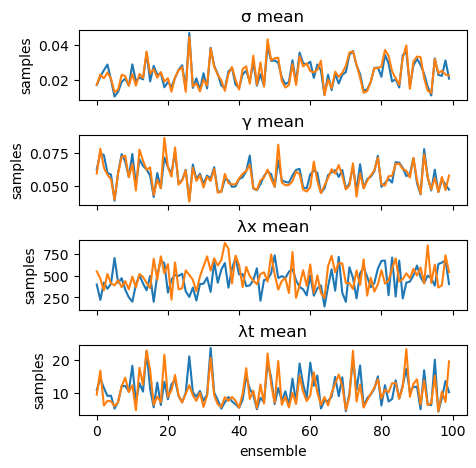

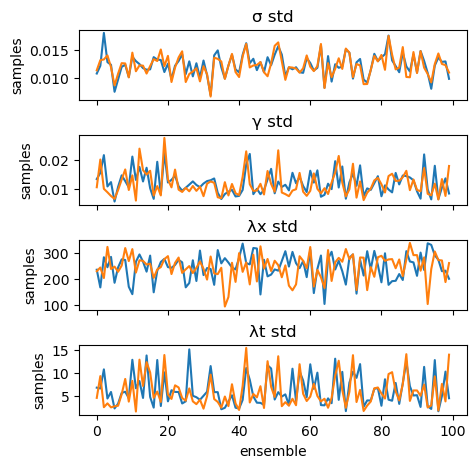

In [8]:
show_convergence(ds)

#### Effective sample size

In [9]:
samples = ds.samples.isel(ensemble=0).values
samples_az = st.convert_to_az(samples, labels)
Ndof = az.ess(samples_az)
print(Ndof)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    σ        float64 253.2
    γ        float64 117.0
    λx       float64 9.687
    λt       float64 85.95


#### MAP

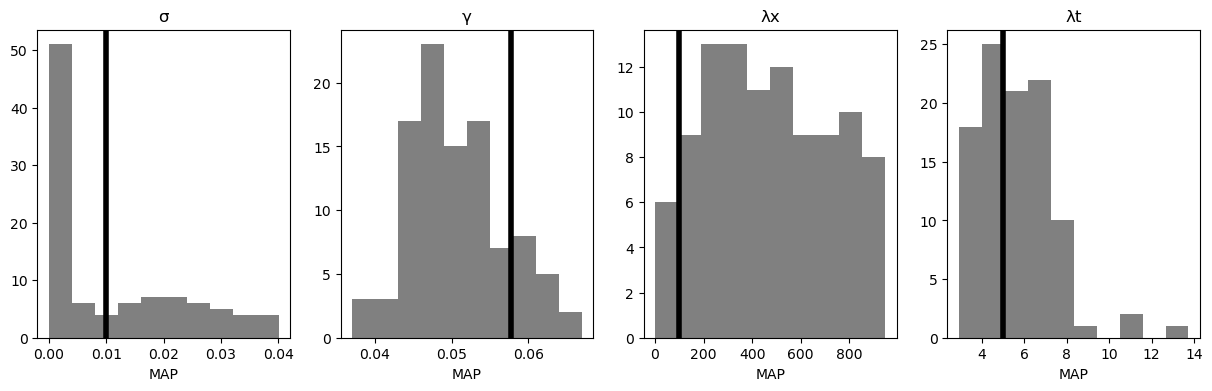

In [10]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _ds.MAP.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)) #+ " - MAP"
    ax.axvline(_tr, color="k", lw=4)

#### mean/std

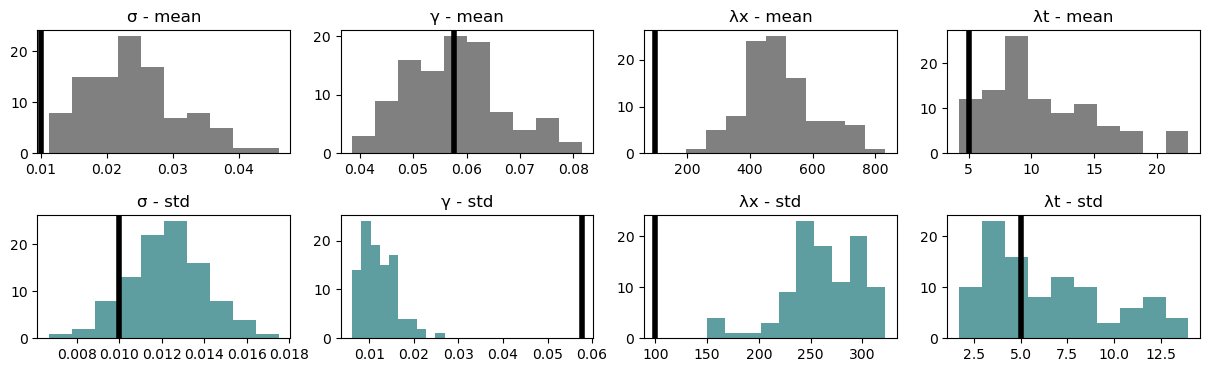

In [11]:
fig, axes = plt.subplots(2, ds.parameter.size, figsize=(15,4), gridspec_kw=dict(hspace=.5))

# mean
for p, ax in zip(ds.parameter, axes[0,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.mean("i")
    _da.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)+" - mean")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")
    
# std
for p, ax in zip(ds.parameter, axes[1,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.std("i")
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.set_title(str(p.values)+ " - std")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")

#### quantiles

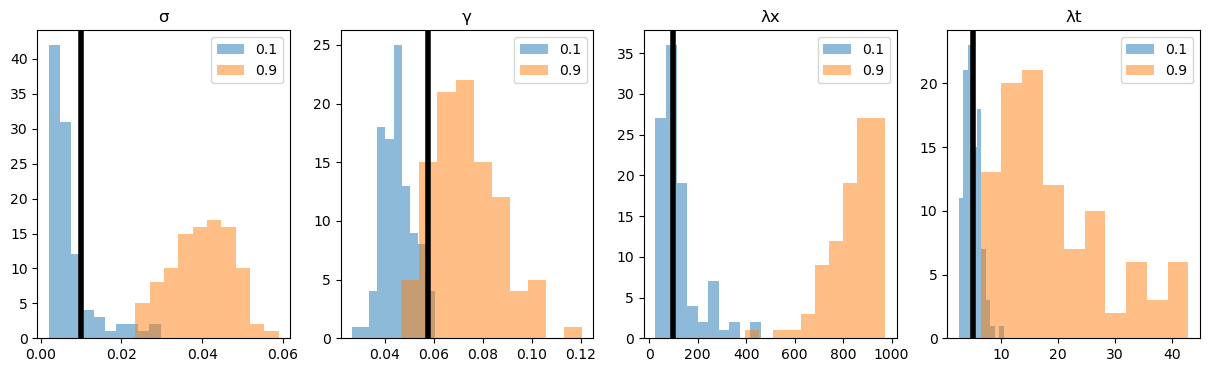

In [12]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    for q in qt:
        _da.sel(quantile=q).plot.hist(ax=ax, bins=10, alpha=.5, label=f"{q}")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")
    ax.legend()

##### quantiles 0.1 0.9 difference

this larger than std by a factor of about 2

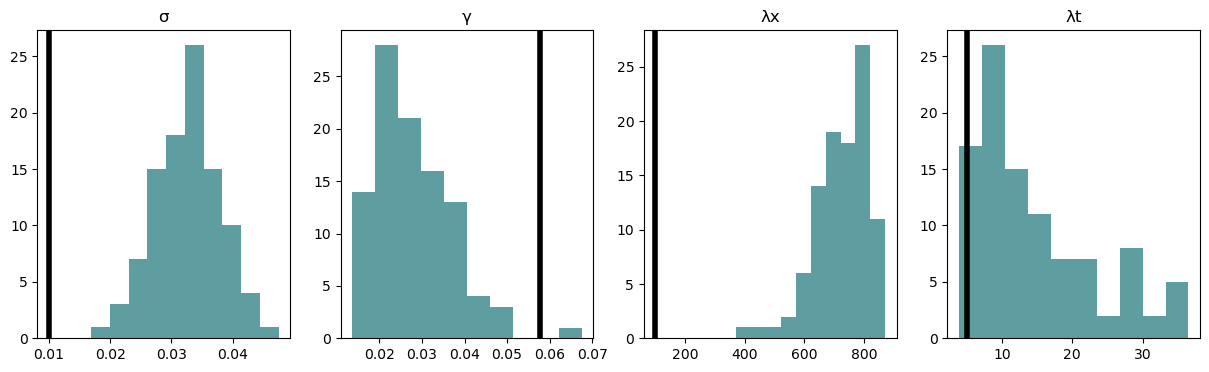

In [13]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _da = _da.sel(quantile=qt[1]) - _da.sel(quantile=qt[0])
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")

---
## drifter inference

- Lagrangian simulation
- actual inference


In [6]:
# wrapper
def load_drifter(Nxy, dx):
    print(Nxy, dx)

    # build output file name    
    nc = os.path.join(data_dir, case+f"_drifters_ensemble_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")

    ds = xr.open_dataset(nc)
    ds["parameter"] = ds.parameter.astype(str)

    return ds

Dr = []
for n in Nxy:
    Dr.append(load_drifter(n, dx))
ds = Dr[0]

1 None
2 None
4 None
8 None
16 None


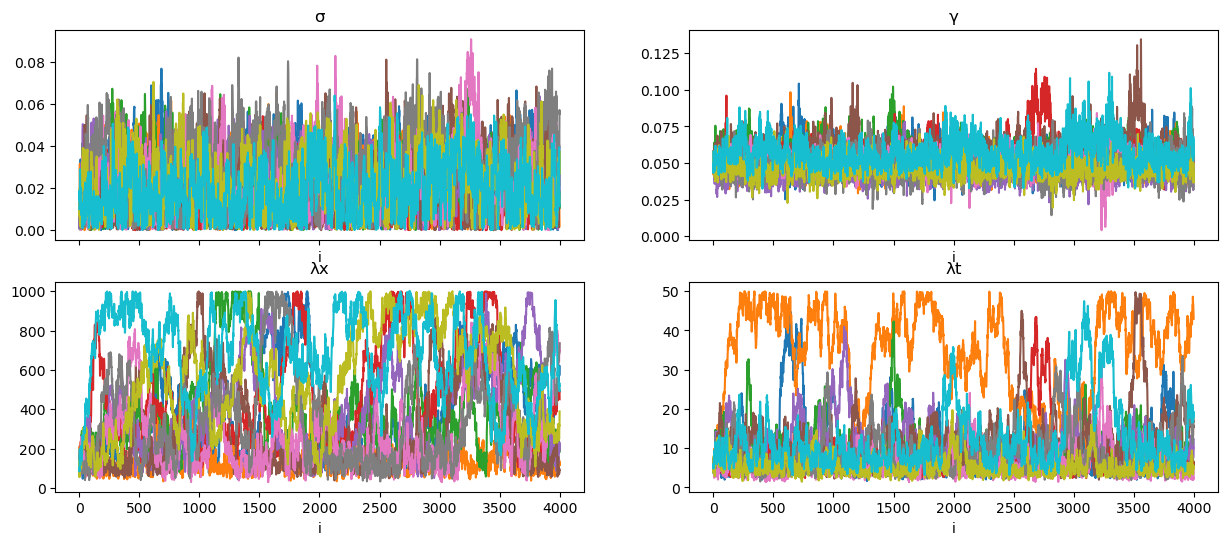

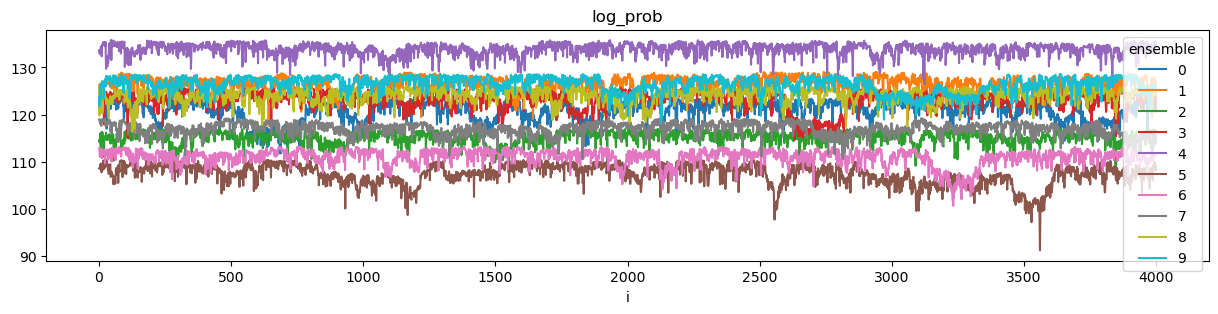

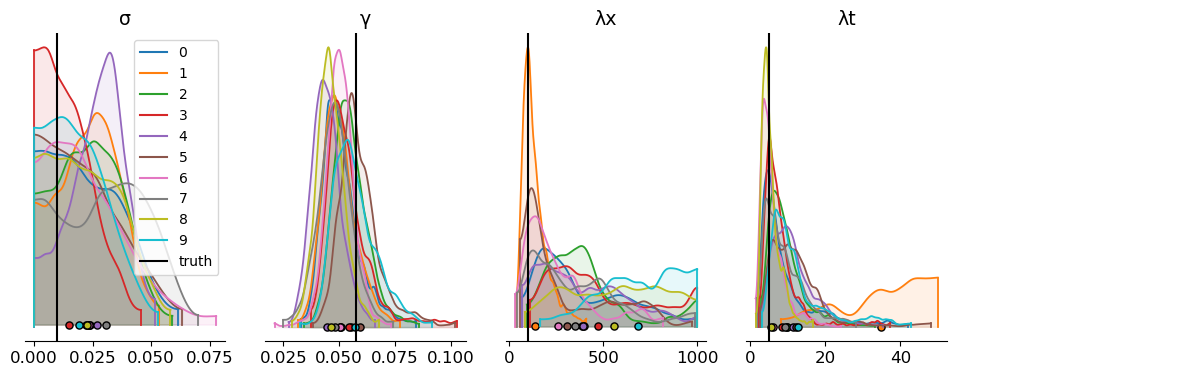

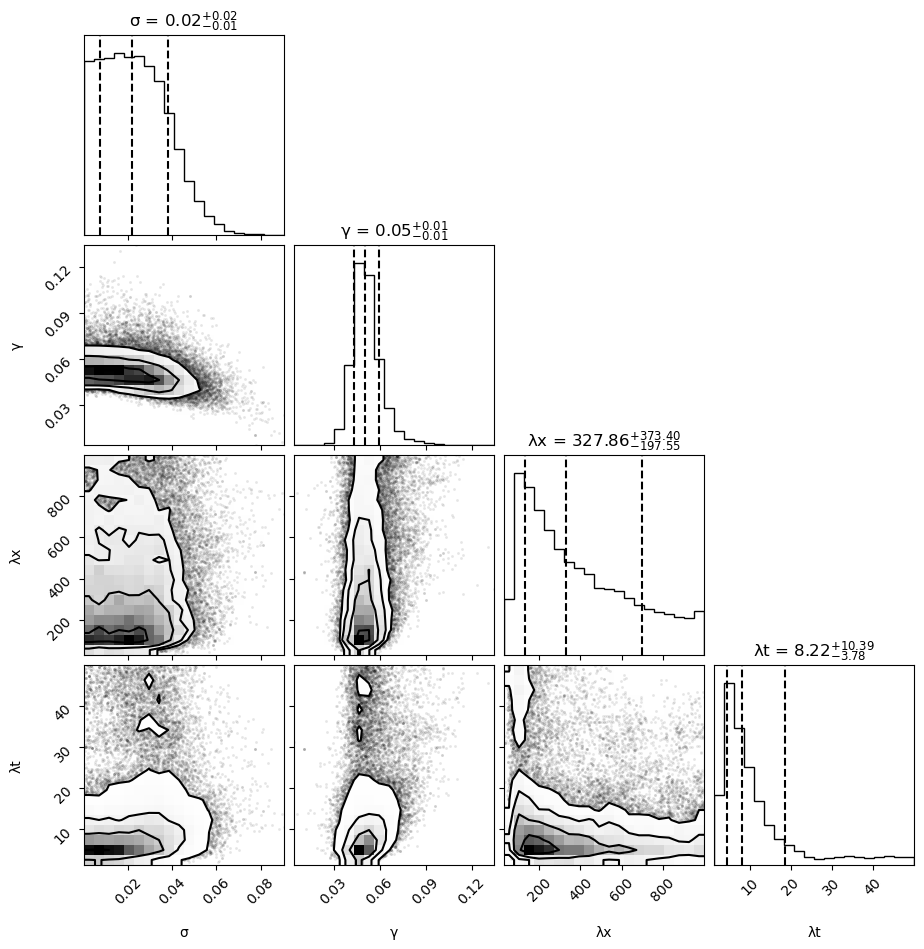

In [15]:
_ds = ds.sel(ensemble=slice(0,10))
st.traceplots(_ds, MAP=False)
st.plot_inference(_ds, xlim=False)

#### MAP

The underestimation of $\gamma$ may be related to interference with the noise parameter inference (see joint distributions above) and the fact we allow for substantial values of the noise compared to the $\gamma$ ... to be verified

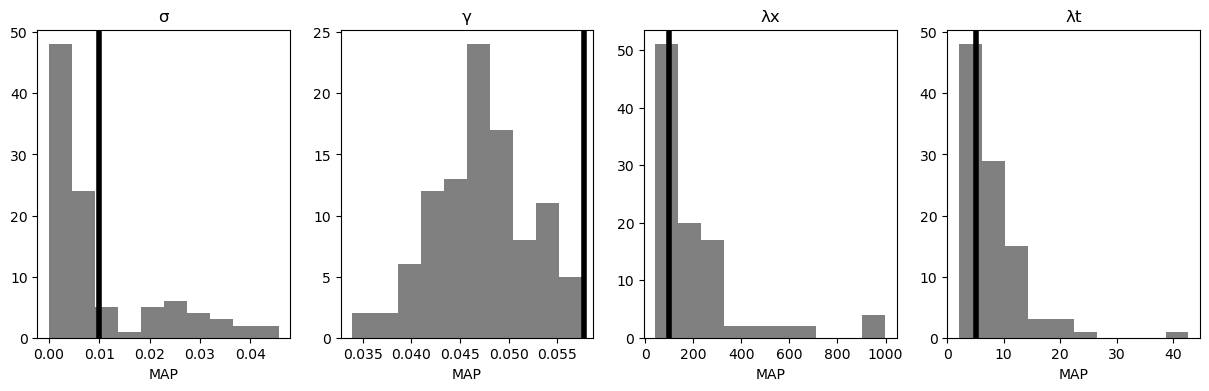

In [16]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _ds.MAP.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)) #+ " - MAP"
    ax.axvline(_tr, color="k", lw=4)

#### mean/std

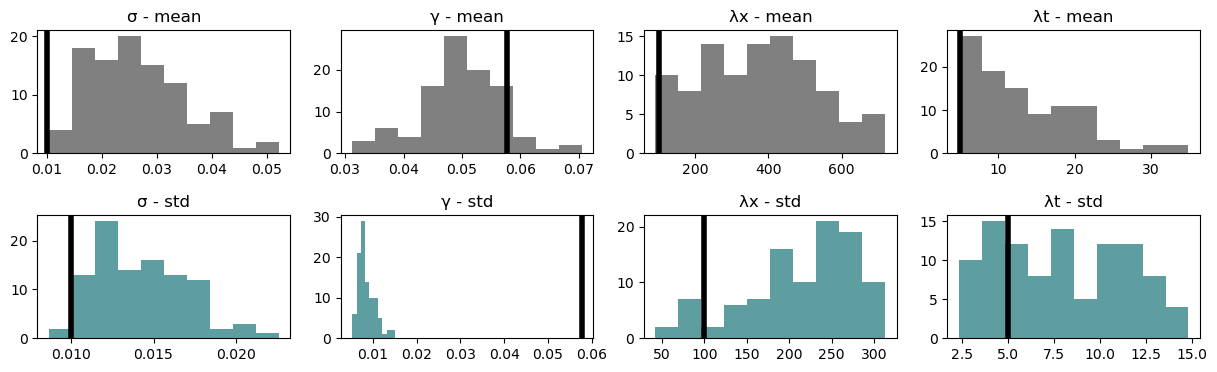

In [17]:
fig, axes = plt.subplots(2, ds.parameter.size, figsize=(15,4), gridspec_kw=dict(hspace=.5))

# mean
for p, ax in zip(ds.parameter, axes[0,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.mean("i")
    _da.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)+" - mean")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")
    
# std
for p, ax in zip(ds.parameter, axes[1,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.std("i")
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.set_title(str(p.values)+ " - std")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")

#### quantiles

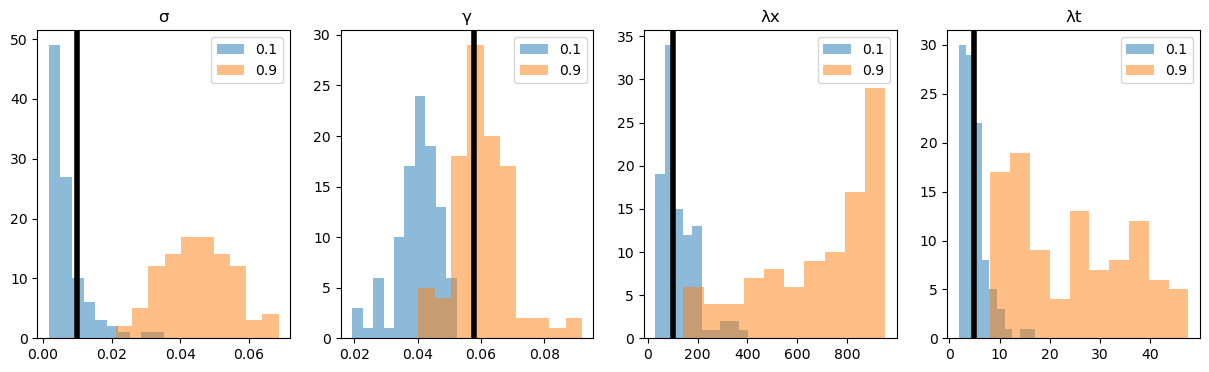

In [18]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    for q in qt:
        _da.sel(quantile=q).plot.hist(ax=ax, bins=10, alpha=.5, label=f"{q}")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")
    ax.legend()

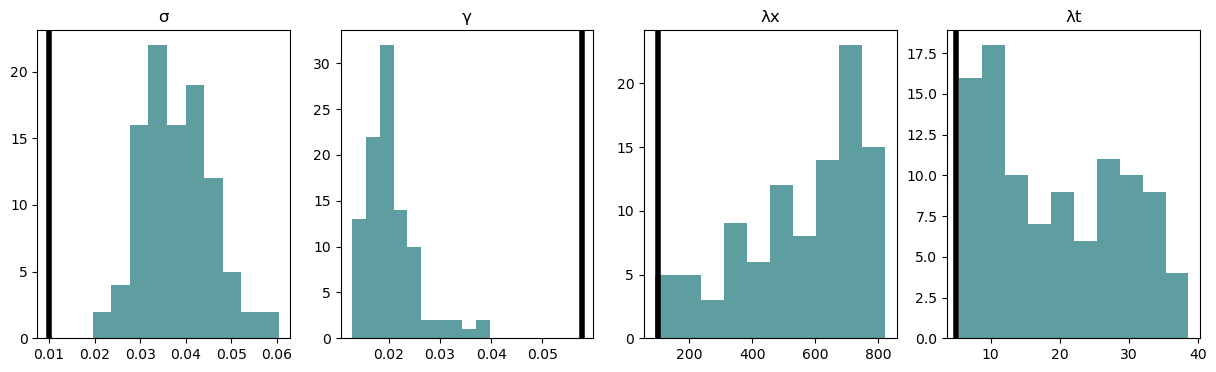

In [19]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _da = _da.sel(quantile=qt[1]) - _da.sel(quantile=qt[0])
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")

---

## results summary

In [7]:
def _pprocess(ds, n):
    ds = ds.copy()
    #print(ds["flow_scale"])
    for v in ["true_parameters", "survival_rate", "lower", "upper"]:
        if v in ds:
            ds[v] = ds[v].isel(ensemble=0)
    #ds["U"] = float(U) * ds.flow_scale
    #λt = float(ds["true_parameters"].sel(parameter="λt"))
    #λx = float(ds["true_parameters"].sel(parameter="λx"))
    ds["Nxy"] = n
    ds = (ds
    #  .assign_coords(α = ds["U"] * λt*day/(λx*1e3))
      .set_coords("true_parameters")
    )
    return ds

dsm = xr.concat([_pprocess(d, n) for d, n in zip(Dm,Nxy)], "Nxy")
dsr = xr.concat([_pprocess(d, n) for d, n in zip(Dr,Nxy)], "Nxy")

In [9]:
bounds = dict(
    σ=(-.005,.05),
    γ=(.02,.08),
    λx=(-50,1100),
    λt=(-1, 15),
)
# common kwargs
kw = dict(x="Nxy", xlog2=True, x_ticks_free=False, bounds=bounds)

/home1/datawork/aponte/code/nwa/nwatools/stats.py:1530: RuntimeWarning: divide by zero encountered in log2
  return np.log2(x)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/indep_platforms_MAP.eps .
scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/indep_platforms_MAP.png .


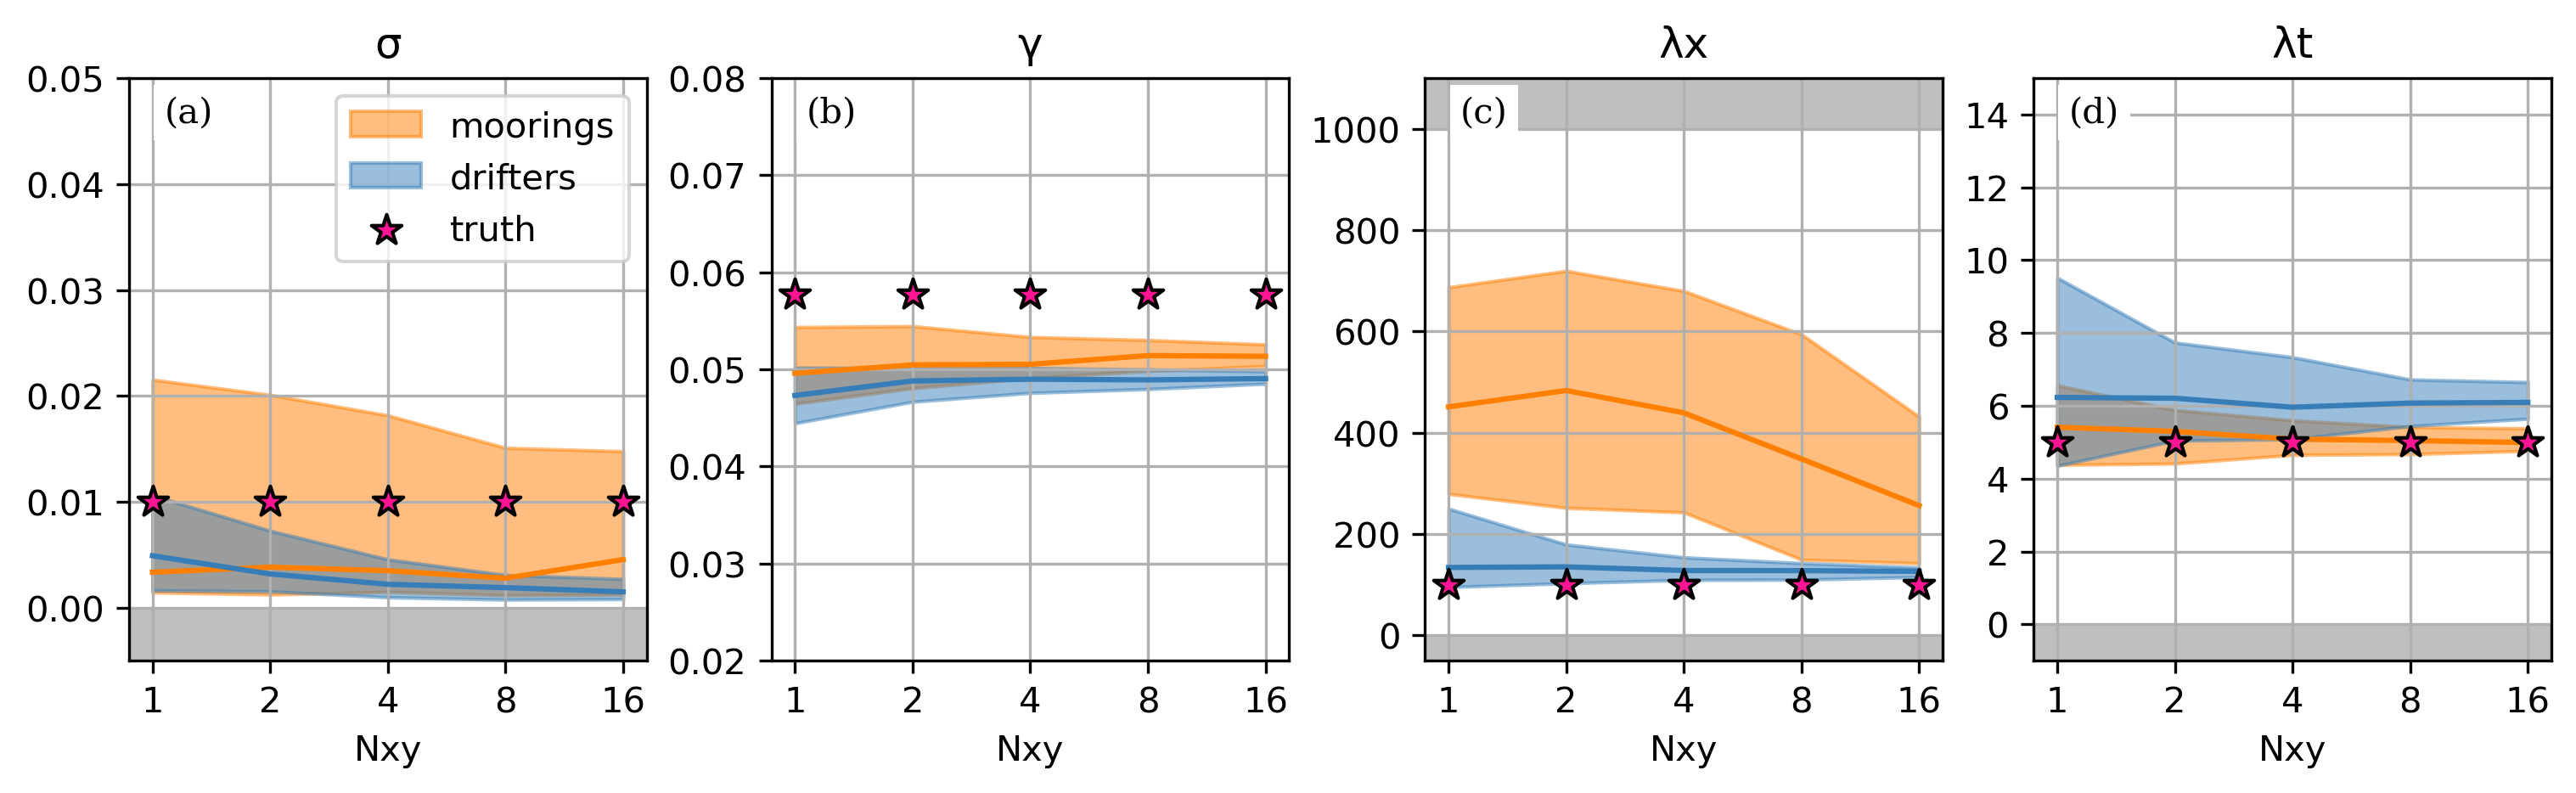

In [10]:
fig, axes = st.plot_sensitivity_combined(dsm, dsr, alpha=0.5, **kw)
st.label_and_print(fig, axes, "indep_platforms_MAP")

In [ ]:
fig, axes = st.plot_sensitivity_combined(dsm, dsr, type="boxplot", **kw)
#st.label_and_print(fig, axes, "indep_platforms_MAP")

/dev/shm/pbs.8269970.datarmor0/ipykernel_52347/1362182775.py:125: RuntimeWarning: divide by zero encountered in log2
  return np.log2(x)


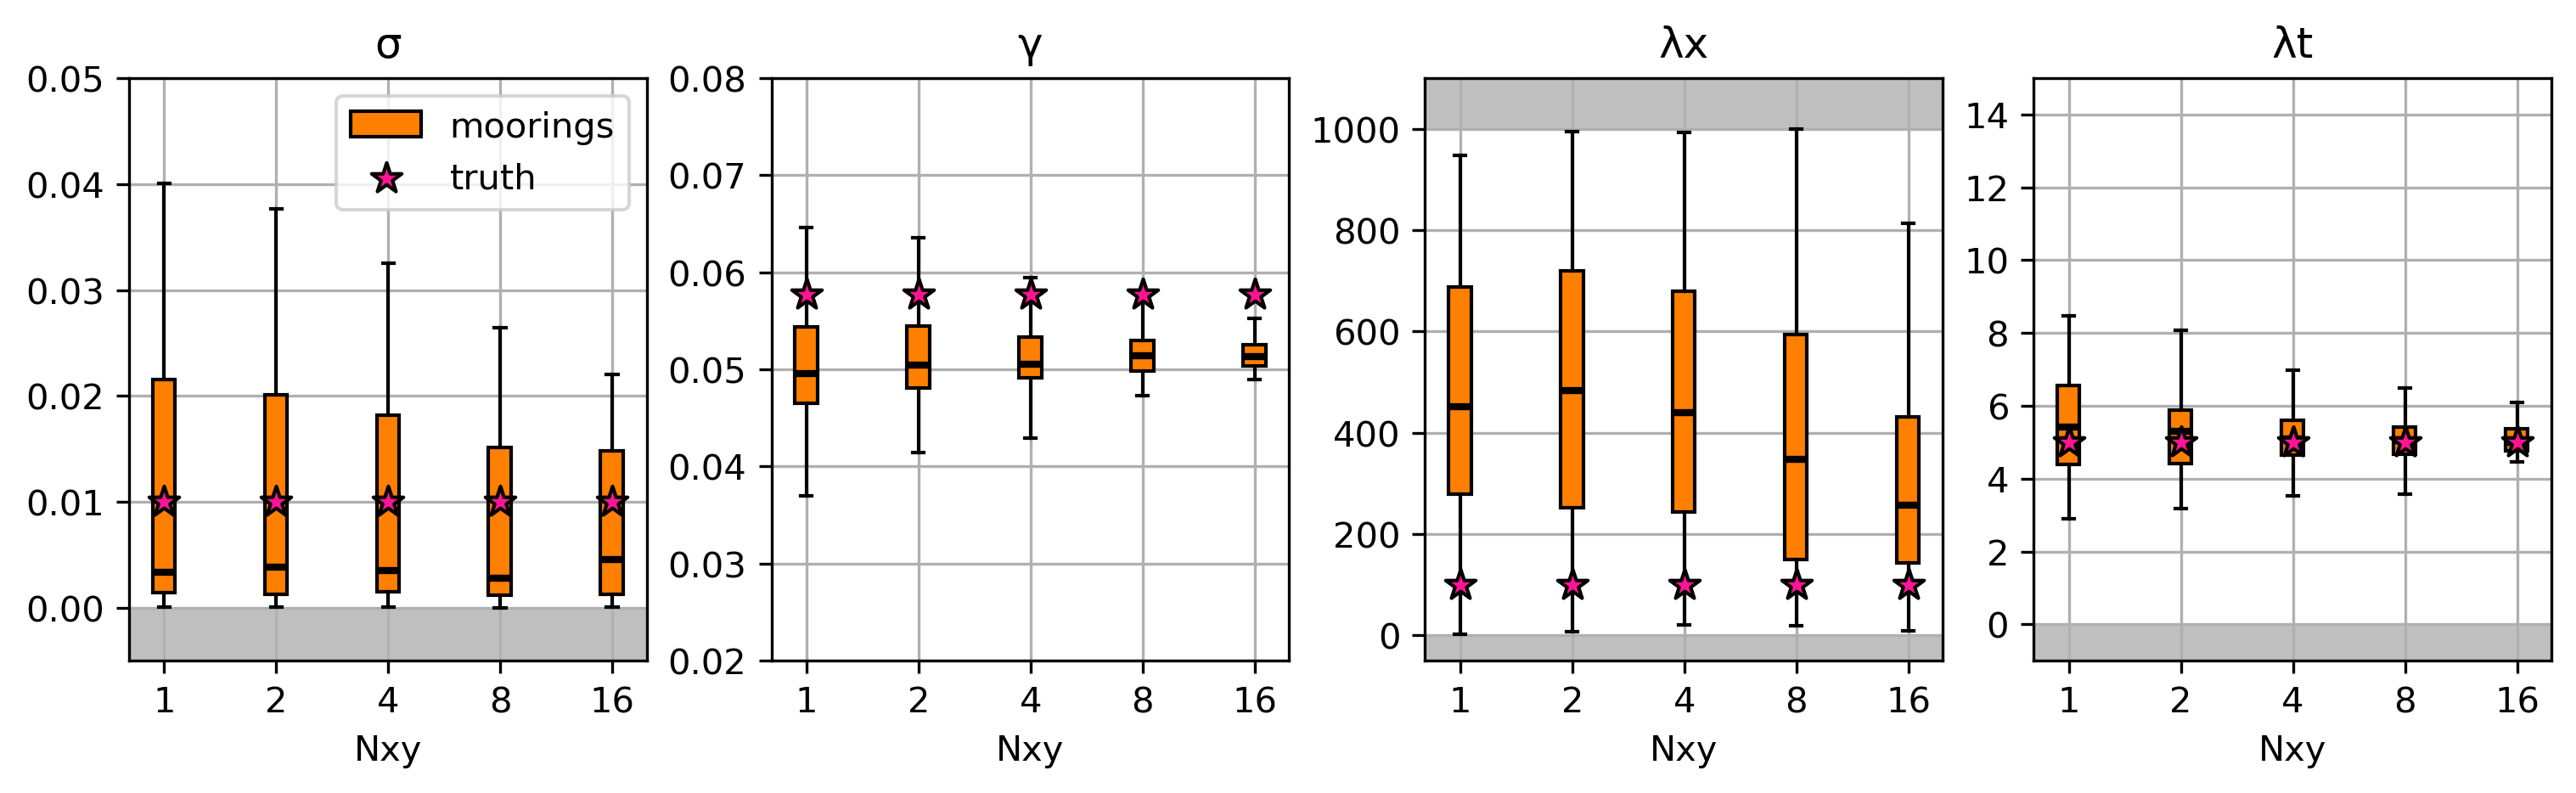

In [54]:
fig, axes = plot_sensitivity(dsm, None, x="Nxy", xlog2=True, x_ticks_free=False, bounds=bounds, label="moorings")

/dev/shm/pbs.8269970.datarmor0/ipykernel_52347/1362182775.py:125: RuntimeWarning: divide by zero encountered in log2
  return np.log2(x)


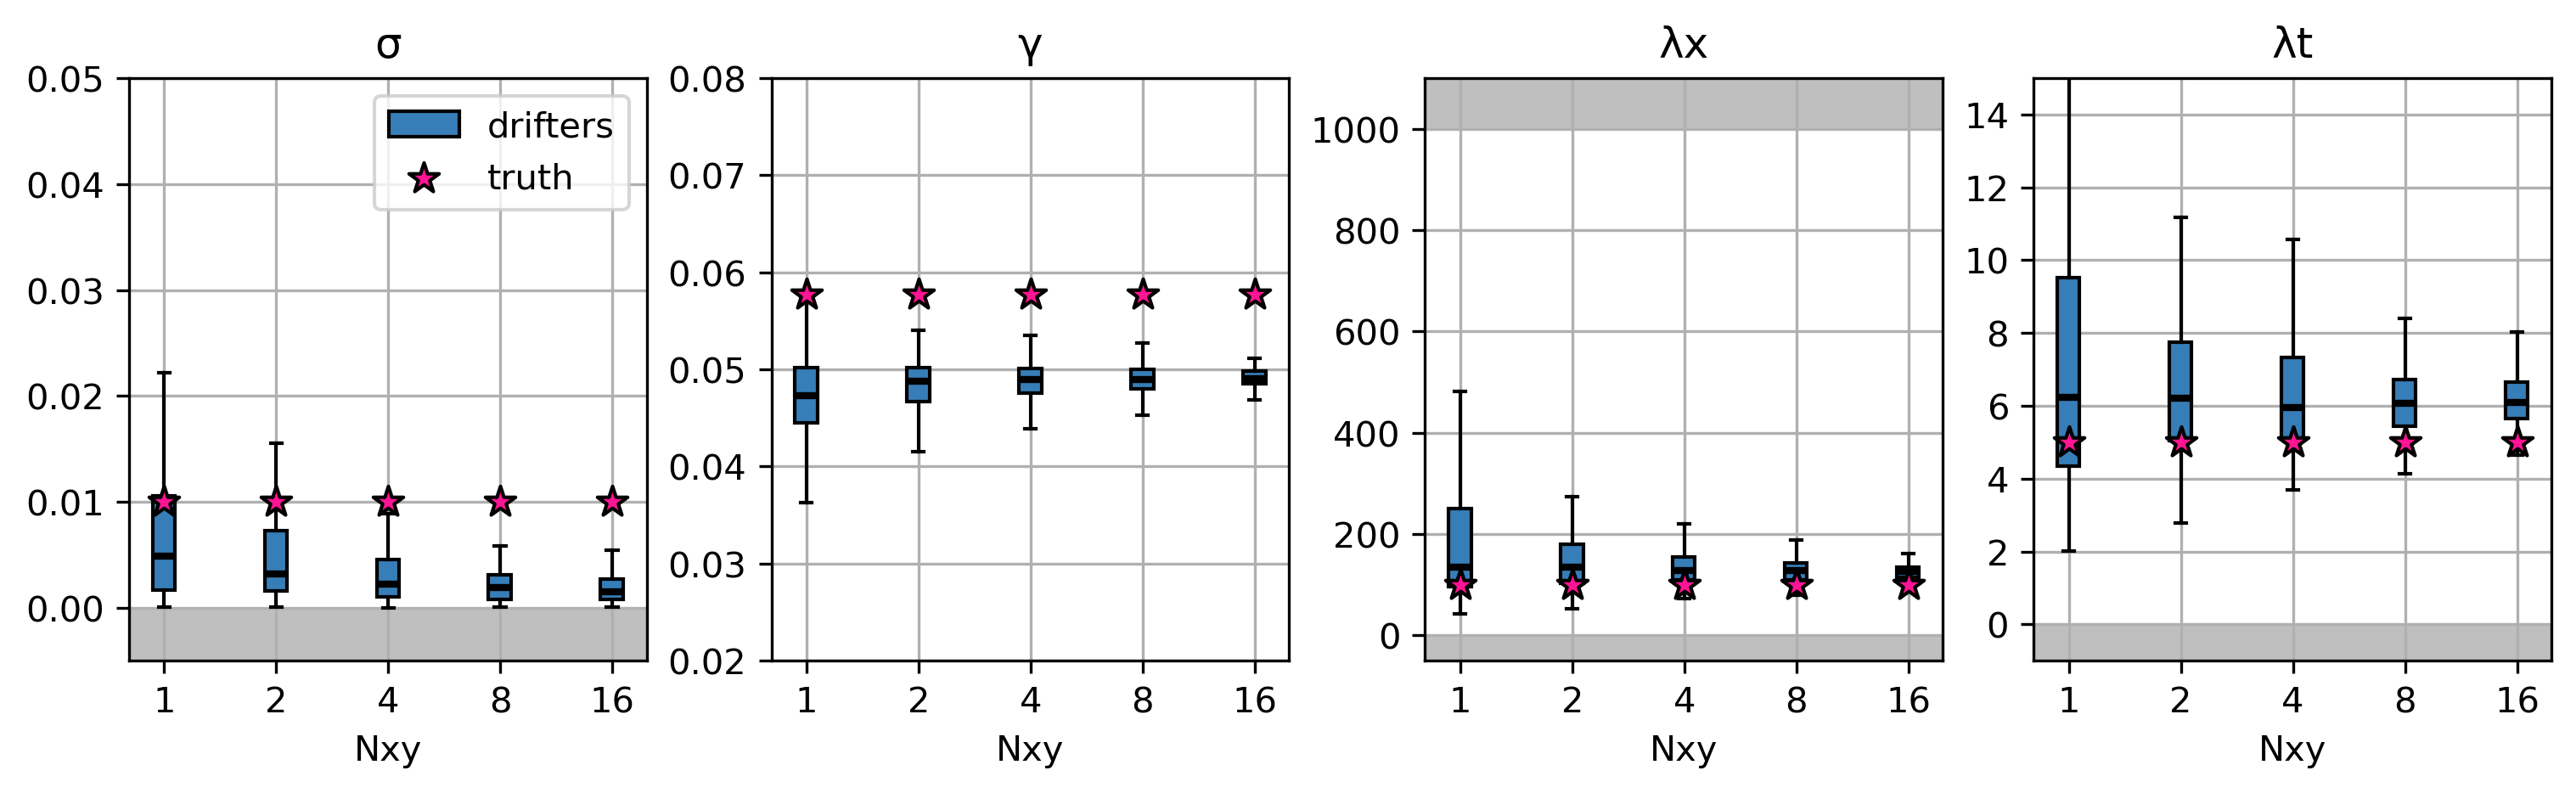

In [55]:
fig, axes = plot_sensitivity(dsr, None, c=c_dr, x="Nxy", xlog2=True, x_ticks_free=False, bounds=bounds, label="drifters")

----

In [16]:
cluster.close()